In [1]:
import argparse
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.utils.validation import check_is_fitted, check_X_y, check_array
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils import shuffle
from sklearn.datasets import load_svmlight_file

# from SU_Classification.misc import load_dataset, convert_su_data_sklearn_compatible
# from SU_Classification.su_learning import SU_Base, SU_SL, SU_DH

import main
# import load_dataset as ld

import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, minmax_scale
from tqdm import tqdm

# Initalization

In [2]:
# PairBoost
# Initialization
sample_size=1000
num_rank_model=1
sigma_k = [5]#,3,4,3,6,5,4,3,3.5,5]
assert len(sigma_k)==num_rank_model, 'Number of rank models and sigma_k should be equal.'
T=10

#SU_classification
n_s=200
n_u=sample_size - 2* n_s
# SU = SU_DH
# x_s, x_u , x_test, y_test = load_dataset(n_s, n_u, n_test, prior)
# x_train, y_train = convert_su_data_sklearn_compatible(x_s, x_u)

# Load Adult dataset

In [3]:
# d = ld.AdultDataset(data_dir='./data/adult')
# x,label_train = d.load_data()
x, label_train = load_svmlight_file('data/adult/a5a.txt', n_features=123)
x = x.toarray()
random_samples = np.random.permutation(x.shape[0])[:sample_size]
x = x[random_samples,:]
label_train = (label_train - 0.5) * 2
label_train = label_train[random_samples]
data_dim = x.shape[1]

scaler = StandardScaler()
x = scaler.fit_transform(x)

# d = ld.AdultDataset(data_dir='./data/adult', subset='test')
# x_test,label_test = d.load_data()
x_test, label_test = load_svmlight_file('data/adult/a5a.t', n_features=123)
x_test = x_test.toarray()
x_test = scaler.transform(x_test)
label_test = (label_test - 0.5) * 2

# Load syntetic dataset

In [26]:
def gen(n, dim, mean=2, var=1):
    return np.random.normal(mean, var, size=(n, dim))

def synth_dataset(ns, nu, prior, nt, dim=2, mp=2):
    nsp = np.random.binomial(ns, prior**2 / (prior**2 + (1-prior)**2))
    nsn = ns - nsp
    xsp = np.hstack((gen(nsp, dim,mean=mp), gen(nsp, dim,mean=mp)))
    xsn = np.hstack((gen(nsn, dim, mean=-mp), gen(nsn, dim, mean=-mp)))
    xs = np.concatenate((xsp,xsn))
    xsr = np.concatenate((xsp.reshape(-1, dim),xsn.reshape(-1, dim)))
    yr = np.concatenate((np.ones(2*nsp),-np.ones(2*nsn)))
    

    nup = np.random.binomial(nu, prior)
    nun = nu - nup
    xu = np.concatenate((gen(nup, dim,mean=mp), gen(nun, dim,mean=-mp)))
    yu = np.concatenate((np.ones(nup), -np.ones(nun)))
    
    x_train = np.concatenate((xsr,xu))
    y_train = np.concatenate((yr,yu))
    x_train,y_train = shuffle(x_train,y_train)
    
    
    ntp = np.random.binomial(nt, prior)
    ntn = nt - ntp
    x_test = np.concatenate((gen(ntp, dim,mean=mp), gen(ntn, dim,mean=-mp)))
    y_test = np.concatenate((np.ones(ntp), -np.ones(ntn)))

    return xs, xu, x_train, y_train, x_test, y_test

x_s, x_u, x_train, y_train, x_test, y_test = synth_dataset(ns=n_s, nu=n_u, prior=0.6, nt=100, mp=1.0)

## Get data for SU_classification

In [ ]:
# est_prior = np.sum(label_train == 1) / (np.sum(label_train == 1) + np.sum(label_train == -1))
# x_pos = x[label_train==1,:]
# x_neg = x[label_train==-1,:]
# random_samples_pos = np.random.permutation(x_pos.shape[0])
# random_samples_neg = np.random.permutation(x_neg.shape[0])

# x_s = np.concatenate((x_pos[random_samples_pos[:n_s]],x_neg[random_samples_neg[:n_s]]))
# x_u = np.concatenate((x_pos[random_samples_pos[n_s:]],x_neg[random_samples_neg[n_s:]]))
# x_train = np.concatenate((x_s,x_u))
# y_train = np.concatenate((np.ones(x_s.shape[0]), np.zeros(x_u.shape[0])))
# x_train,y_train = shuffle(x_train,y_train)

# SU_Classification training

In [ ]:
lam_list = [1e-01, 1e-04, 1e-07]
score_cv_list = []
x_train_su, y_train_su = convert_su_data_sklearn_compatible(x_s, x_u)
for lam in lam_list:
    clf = SU(prior=0.6, lam=lam)
    score_cv = cross_val_score(clf, x_train_su, y_train_su, cv=5).mean()
    score_cv_list.append(score_cv)

In [ ]:
lam_best = lam_list[np.argmax(score_cv_list)]
clf = SU(prior=0.7, lam=lam_best)
clf.fit(x_train_su, y_train_su)

In [ ]:
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

# PairBoost

## Learn the ranker

In [27]:
ranks = []
# n_samples = int(np.sqrt(2*n_s))+1
n_samples = 2 * n_s + n_u
x = x_train[:n_samples]
label_train = y_train[:n_samples]
# for i in range(num_rank_model):
#     c=round(np.random.uniform(low=1.0, high=1.5), 1)
#     clf = SVC(kernel='linear',max_iter=2000,C=c)
#     clf.fit(x, label_train)
#     ranks.append(clf.decision_function(x))
#     ranks_test.append(clf.decision_function(x_test))
#     print('Accuracy of the trained SVM with C = {} is: {}'.format(c,clf.score(x,label_train)))

pos_ind = np.squeeze(np.argwhere(y_train == 1))
neg_ind = np.squeeze(np.argwhere(y_train == -1))
pos_ind = pos_ind[np.random.permutation(pos_ind.shape[0])[:n_s]]
neg_ind = neg_ind[np.random.permutation(neg_ind.shape[0])[:n_s]]
rnd_c = np.random.choice([1,-1],[pos_ind.shape[0],1])
x_pair = (x_train[pos_ind,:] - x_train[neg_ind,:]) * rnd_c
y_pair = (y_train[pos_ind] - y_train[neg_ind]) * np.squeeze(rnd_c)
for i in range(num_rank_model):
    c=round(np.random.uniform(low=1.0, high=1.5), 1)
    clf = SVC(kernel='linear',max_iter=2000,C=c)
    clf.fit(x_pair, y_pair)
    ranks.append(clf.decision_function(x))
#     ranks_test.append(clf.decision_function(x_test))
    print('Accuracy of the trained SVM with C = {} is: {}'.format(c,clf.score(x_pair,y_pair)))



Accuracy of the trained SVM with C = 1.4 is: 0.96


## Learn probabilities

In [28]:
W = [main.gen_conf_matrix(rank, sigma) for rank,sigma in zip(ranks,sigma_k)]
# Approximate, faster version
# W = [main.gen_conf_matrix1(rank, sigma) for rank,sigma in zip(ranks,sigma_k)]


# Select random pairs
# m = int(np.sqrt(2*n_s))+1
# pos_ind = np.squeeze(np.argwhere(label_train == 1))
# neg_ind = np.squeeze(np.argwhere(label_train == -1))
# pos_ind = pos_ind[np.random.permutation(pos_ind.shape[0])[:m]]
# neg_ind = neg_ind[np.random.permutation(neg_ind.shape[0])[:m]]
# W = [w[pos_ind,:][:,neg_ind] for w in W]


In [29]:
""" NEIL'S CELL """
from main import *
W = generate_rank_W(x_train, y_train, 200)
W = [W]

## Train the model

In [30]:
t=0
data_dim=2
alpha=[0.0]
f = [np.zeros((1,data_dim)),0.0]
n = x.shape[0]

with tqdm(total=T) as it:
    while (t <= T) and (alpha[-1] >= 0):
        scores = f[0].dot(x.T) + f[1]
        scores = minmax_scale(scores,feature_range=(-1,1),axis=1)
        xi = main.cal_uncertainty(scores,W)
        weights = main.cal_weights(xi)
        labels = np.sign(weights)
        minmax_scale(scores,feature_range=(-1,1),axis=1)
        
        # Bootstraping data
        p_weights = weights - np.min(weights)
        p_weights /= np.sum(p_weights)
        new_samples = np.random.choice(n,4*n,p=p_weights)
        new_x = x[new_samples,:]
        new_label_train = labels[new_samples]
        
        # Learning a linear SVM for the binary classifcation
        clf = SVC(kernel='linear')
        new_x, new_label_train = shuffle(new_x,new_label_train)
        clf.fit(new_x, new_label_train)
        y = clf.predict(x)
        print('Accuracies for training and test:')
        predicted_score = clf.score(x,label_train)
        print(max(predicted_score,1-predicted_score))
        print(max(clf.score(x_test,y_test),clf.score(x_test,-y_test)))
        # Calculate alpha
        alpha_t = main.cal_alpha(y, xi)
        alpha.append(alpha_t)
                
        # Update classifier
        f[0] += alpha[t] * clf.coef_
        f[1] += alpha[t] * clf.intercept_

        y_pred = np.sign(f[1] + np.squeeze(np.matmul(x_test, f[0].T)))
        print('Overall Test Accuracy:', accuracy_score(y_test, y_pred), '\n')

        t += 1
        #it.update()
    


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracies for training and test:
0.913
0.96
Overall Test Accuracy: 0.0 

Accuracies for training and test:
0.907
0.96
Overall Test Accuracy: 0.96 



/Users/Ashtekar15/Desktop/Thesis/PairBoost/main.py:98: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.log(np.sum(I_1) / np.sum(I_2))
  0%|          | 0/10 [00:00<?, ?it/s]

Accuracies for training and test:
0.626
0.61
Overall Test Accuracy: 0.94 



In [36]:
svm_lambdaboost(x_train, label_train, x_test, y_test, W[0], T=10, sample_prop=4)

LINEAR SVM SUBMODELS
Using 10 classifiers and sample proportion of 4
t	Train		Test
1	0.915		0.960
2	0.914		0.960
3	0.915		0.960
4	0.915		0.960
5	0.915		0.960
6	0.915		0.960
7	0.915		0.960
8	0.915		0.960
9	0.915		0.960
10	0.913		0.960
Done!


(0.08699999999999997, 0.040000000000000036)

In [23]:
f

[array([[1.99121678, 1.02402192]]), array([0.94505876])]

In [24]:
xq = np.array([-4, 4])
# yq = (152.20063179 - (137.11042097 * xq)) / 163.13538911
yq = (-f[1][0] - (f[0][0, 0] * xq)) / f[0][0, 1]

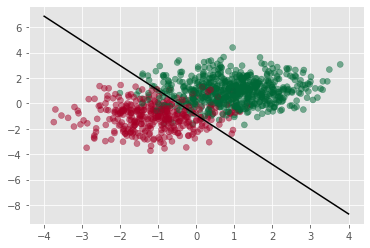

In [25]:
import matplotlib.pyplot as plt

plt.scatter(x_train[:, 0], x_train[:, 1], c=label_train, alpha=0.5, cmap='RdYlGn')
plt.plot(xq, yq, color='black')